# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

In [ ]:
#Librerías que vamos a usar 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import numpy as np

In [ ]:
data = pd.read_csv('/datasets/taxi.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [ ]:
#Cambiamos el tipo de datos de la columna datetime de tipo object a datetime64(parse_dates)
#Establecemos la columna datetime como el indice de nuestra tabla (index_col)
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [ ]:
#Explorando valores ausentes
data.isna().sum()

num_orders    0
dtype: int64

No tenemos valores ausentes en nuestro conjunto de datos y se han cambiado al formato adecuado para poder trabajar con ellos. 

## Preparación

### Orden de nuestro indice 

In [ ]:
data.sort_index(inplace=True) #Ordenamos cronologicamente el index. 
print(data.index.is_monotonic) #Usamos el método is_monotonic para comprobar si el indice está en orden cronologico 
print(data.info())

True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


In [ ]:
#Vemos el rango que tienen nuestros datos
print(data.index.min())
print(data.index.max())

2018-03-01 00:00:00
2018-08-31 23:50:00


<AxesSubplot:xlabel='datetime'>

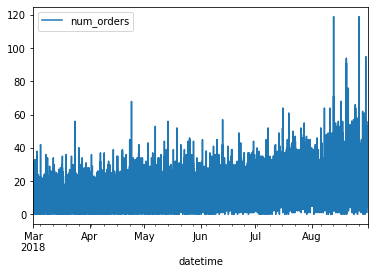

In [ ]:
#Gráficamos nuestros datos
data.plot()

### Agrupando por horas

<AxesSubplot:xlabel='datetime'>

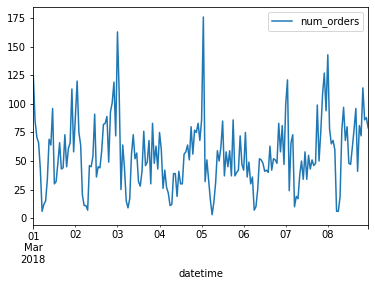

In [ ]:
#Utilizamos el método de remuestreo para que agrupe los datos por hora
data = data.resample('1H').sum()
data['2018-03-01': '2018-03-08'].plot() #Graficamos la primera semana de nuestros datos

Podemos ver en el agrupamiento de nuestra serie que existe algo de estacionalidad. 

### Creación de características

Vamos a escribir la función `make_features` para agregar características a nuestro conjunto de datos: 
- Características de calendario: `year, month, day, dayofweek`
- Caracteríticas de desfase: `lag_1, lag_2, lag_3, lag_4, lag_5, lag_6`
- Media móvil: `rolling_mean`

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

 
    data['rolling_mean'] = (
        data['num_orders'].shift().rolling(rolling_mean_size).mean()#La media móvil en t considera el valor actual de la serie x(t), 
                                                                                                         #el cual no queremos porque el valor actual pertenece al objetivo y no a las características.
                                                                                                        #Así que usamos características de desfase para excluir el valor actual
    )
make_features(data, 30, 10)

Ya tenemos nuestras características completas con las que trabajaremos. Los valores anteriores al primer valor de las columnas de desfase son valores nulos los cuales debemos eliminar para entrenar a nuestros modelos. 

## Análisis

### Características y objetivo para entrenar los modelos 

In [ ]:
#Dividimos nuestros datos en test y train
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna() #Eliminamos los valores nulos

#Seleccionamos nuestro conjunto de datos de entrenamiento y prueba
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

### Pruebas de cordura 

In [ ]:
print('Mediana de la cantidad de pedidos:', test['num_orders'].median())
pred_median = np.ones(test.shape) * train['num_orders'].median()
rmse_pc = sqrt(mean_squared_error(test, pred_median))
print('RMSE:', rmse_pc)

Mediana de la cantidad de pedidos: 135.0
RMSE: 334.41598250750593


In [ ]:
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
print('RMSE:', sqrt(mean_squared_error(test, pred_previous)))

RMSE: 55.07790510124618


La primera prueba la hicimos con valores constantes, en ese caso fue con la mediana de los datos. La segunda prueba se hizo con el valor anterior de la serie. El menor resultado de error fue con la segunda prueba del valor anterior.

### LinearRegression

In [ ]:
%%time
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)

pred_train_lr = model_lr.predict(features_train)
pred_test_lr = model_lr.predict(features_test)

rmse_lr = sqrt(mean_squared_error(target_test, pred_test_lr))

print("RMSE para el conjunto de prueba:", rmse_lr)

RMSE para el conjunto de prueba: 46.886340577530895
CPU times: user 11.6 ms, sys: 44.1 ms, total: 55.7 ms
Wall time: 54.5 ms


Nuestro modelo de regresión lineal superó nuestra prueba de congruencia además de tener un valor de RMSE menor que el pedido por la compañía. 

### DecisionTreeRegressor

In [ ]:
%%time
for depth in range(4, 10):
    model_dtr = DecisionTreeRegressor(random_state=12345, max_depth= depth)
    model_dtr.fit(features_train, target_train)
    predictions_test_dtr = model_dtr.predict(features_test)
    rmse_dtr = sqrt(mean_squared_error(target_test, predictions_test_dtr))
    
    print("max_depth =", depth, ": ", end='')    
    print('RMSE:', rmse_dtr) 

max_depth = 4 : RMSE: 54.64617058911393
max_depth = 5 : RMSE: 62.10613399063284
max_depth = 6 : RMSE: 52.935583239138836
max_depth = 7 : RMSE: 64.25258990155996
max_depth = 8 : RMSE: 62.06063452692765
max_depth = 9 : RMSE: 57.40223296726539
CPU times: user 472 ms, sys: 82.6 ms, total: 554 ms
Wall time: 626 ms


En el caso de los árboles de regresión, ninguno de los modelos superó el valor que nos pide la compañía.

### RandomForestRegressor

In [ ]:
%%time

best_model = None
best_result = 10000
best_est = 0
best_depth = 0

for est in range(10, 100,50):
    for depth in range (3,11):
        model_rfr = RandomForestRegressor(random_state=12345,n_estimators=est, max_depth=depth)
        model_rfr.fit(features_train, target_train)
        predictions_test_rfr = model_rfr.predict(features_test) 
        result = sqrt(mean_squared_error(target_test, predictions_test_rfr))
        
        if result < best_result:
            best_model = model_rfr
            best_result = result
            best_est = est
            best_depth = depth

            
print('RMSE:', best_result, 'n_estimators:', best_est, 'best_depth:', best_depth)

RMSE: 43.54776772227 n_estimators: 60 best_depth: 9
CPU times: user 24.7 s, sys: 38.2 ms, total: 24.8 s
Wall time: 24.8 s


Nuestro modelo con el algoritmo Random Forest Regressor tuvo un error de 43, menor que el de la regresión lineal y menor de 48 que es lo que nos pide la compañía. 

### LGBMRegressor

In [ ]:
model = lgb.LGBMRegressor()

#Creando un diccionario con las iteraciones del modelo
grid = dict()
# valores para iterar
grid['learning_rate'] = [0.1, 0.5]
grid['max_depth'] = [-1]
grid['n_estimators'] = [100,150]

In [ ]:
# aplicando el métidi GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=2)
# guardando los valores
grid_result = grid_search.fit(features_train,target_train)
# imprimiendo los mejores parametros
print("Accuracy score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Accuracy score: 0.392674 using {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 100}


In [ ]:
%%time 
model_reg = lgb.LGBMRegressor(**grid_result.best_params_, random_state=12345)
model_reg.fit(features_train,target_train)
reg_pred = model_reg.predict(features_test)
rmse_reg = sqrt(mean_squared_error(target_test, reg_pred))
rmse_reg

CPU times: user 1.19 s, sys: 14.7 ms, total: 1.21 s
Wall time: 1.2 s


41.7587946904251

De los modelos que hemos probado, el que mejor rendimiento ha tenido en relación con la métrica de RMSE ha sido el de LGBMregreressor. Obtuvo un valor menor que el del algoritmo Random Forest Regressor

### XGBRegressor

In [ ]:
from xgboost import XGBRegressor

In [ ]:
%%time
model_XGB = XGBRegressor(random_state=12345)
model_XGB.fit(features_train,target_train)
XGB_pred = model_XGB.predict(features_test)
rmse_xgb = sqrt(mean_squared_error(target_test, XGB_pred))
rmse_xgb

CPU times: user 4.16 s, sys: 22.1 ms, total: 4.18 s
Wall time: 4.21 s


45.615634154285175

Nuestro último modelo obtuvo una métrica menor a 48, sin embargo, no superó al nuestro modelo anterior que fue el que obtuvo el mejor desempeño. 

## Análisis de modelos

De nuestros 5 modelos probados, el que obtuvo mejor desempeño fue `LGBMRegressor` con relación al menor error en sus predicciones. 

In [ ]:
rmse_total = pd.DataFrame({'Algoritmo': ['LinearRegression','DecisionTreeRegressor', 'RandomForestRegressor', 'LGBMRegressor','XGBRegressor'],
    'RMSE': [rmse_lr, rmse_dtr, best_result,rmse_reg, rmse_xgb ]
})

rmse_total

,Algoritmo,RMSE
0,LinearRegression,46.886341
1,DecisionTreeRegressor,57.402233
2,RandomForestRegressor,43.547768
3,LGBMRegressor,41.758795
4,XGBRegressor,45.615634


## Conclusiones 

- Los datos no tenían valores nulos
- Se cambió el tipo de dato de la columna datatime de object a datetime64
- Establecí la columna datatime como el índice de nuestros datos.
- Ordenamos los indices de manera cronologíca
- Agrupamos los valores por horas.
- Hicimos una función para agregar características a nuestro conjunto. 
- Hicimos dos pruebas de cordura, una con un valor constante y la otra con el valor anterior de cada dato.
- Se probaron 5 modelos
- El que mejores resultados obtuvo fue LGBMregressor con una métrica de RMSE de 42